In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
)


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
from replay_trajectory_classification import (
    SortedSpikesDecoder,
    ClusterlessDecoder,
    SortedSpikesClassifier,
    ClusterlessClassifier,
)


In [4]:
from replay_trajectory_classification.sorted_spikes_simulation import (
    make_simulated_run_data,
)

time, position, sampling_frequency, spikes, place_fields = make_simulated_run_data()


In [11]:
place_fields.shape

(360000, 19)

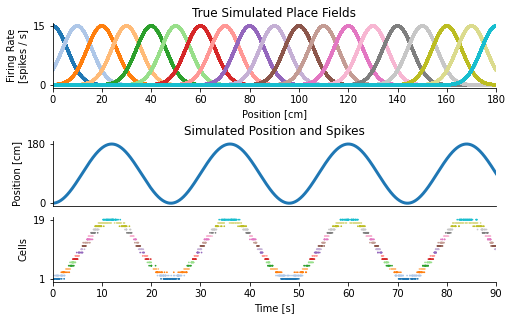

In [9]:
from replay_trajectory_classification.misc import TWO_COLUMN, GOLDEN_RATIO


spike_ind, neuron_ind = np.nonzero(spikes)
cmap = plt.get_cmap('tab20')

fig, axes = plt.subplots(3, 1, figsize=(TWO_COLUMN, TWO_COLUMN * GOLDEN_RATIO), constrained_layout=True)
for place_field, color in zip(place_fields.T, cmap.colors):
    axes[0].plot(position, place_field, linewidth=3, color=color)
axes[0].set_xlabel('Position [cm]')
axes[0].set_ylabel('Firing Rate\n[spikes / s]')
axes[0].set_title('True Simulated Place Fields')
axes[0].set_xlim((position.min(), position.max()))
axes[0].set_yticks([0, np.round(place_fields.max())])

axes[1].plot(time, position, linewidth=3)
axes[1].set_ylabel('Position [cm]')
axes[1].set_title('Simulated Position and Spikes')
axes[1].set_yticks([0, np.round(position.max())])
axes[1].set_xticks([])
axes[1].set_xlim((0.0, 90.0))

c = [cmap.colors[ind] for ind in neuron_ind]
axes[2].scatter(time[spike_ind], neuron_ind + 1, c=c, s=0.5)
axes[2].set_yticks((1, spikes.shape[1]))
axes[2].set_ylabel('Cells')

axes[2].set_xlabel('Time [s]')
axes[2].set_xlim((0.0, 90.0))

sns.despine()

In [12]:
from dask.distributed import Client

Client(n_workers=2,
       threads_per_worker=2,
       processes=True,
       memory_limit='25GB')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 46.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51093,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 46.57 GiB
Comm: tcp://127.0.0.1:51113,Total threads: 2
Dashboard: http://127.0.0.1:51114/status,Memory: 23.28 GiB
Nanny: tcp://127.0.0.1:51097,


In [13]:
from replay_trajectory_classification import SortedSpikesDecoder
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk

movement_var = estimate_movement_var(position, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
transition_type = RandomWalk(movement_var=movement_var)

decoder = SortedSpikesDecoder(
    environment=environment,
    transition_type=transition_type,
    knot_spacing=10)
decoder.fit(position, spikes)

SortedSpikesDecoder(environment=Environment(environment_name='', place_bin_size=0.5268625668325884, track_graph=None, edge_order=None, edge_spacing=None, is_track_interior=None, position_range=None, infer_track_interior=True),
                    infer_track_interior=True,
                    initial_conditions_type=UniformInitialConditions(),
                    knot_spacing=10, spike_model_penalty=10.0,
                    transition_type=RandomWalk(environment_name='', movement_var=0.2775841643294236, movement_mean=0.0, use_diffusion=True))

In [14]:
decoder.place_fields_


<xarray.DataArray (position: 342, neuron: 19)>
array([[0.01415722, 0.00356981, 0.00027872, ..., 0.00020188, 0.00019369,
        0.00016442],
       [0.01365628, 0.00400002, 0.00031883, ..., 0.0001998 , 0.00019097,
        0.00016219],
       [0.01316166, 0.00447772, 0.00036468, ..., 0.00019777, 0.00018833,
        0.00016001],
       ...,
       [0.00015458, 0.00019103, 0.00020069, ..., 0.00026602, 0.00439007,
        0.0154396 ],
       [0.00015665, 0.00019372, 0.00020283, ..., 0.00022782, 0.00390472,
        0.01633649],
       [0.00015877, 0.0001965 , 0.00020503, ..., 0.00019507, 0.00346936,
        0.0172738 ]])
Coordinates:
  * position  (position) float64 0.2632 0.7895 1.316 1.842 ... 178.7 179.2 179.7
Dimensions without coordinates: neuron

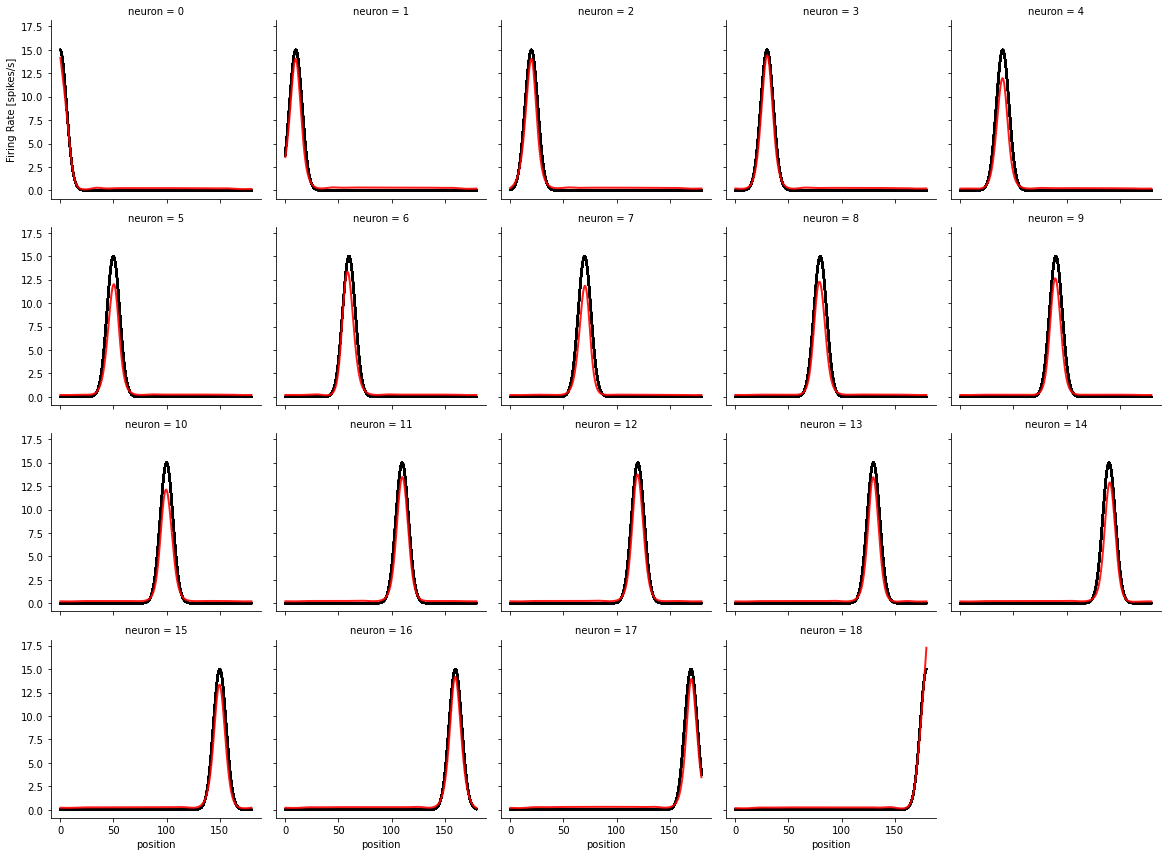

In [15]:
g = (decoder.place_fields_ * sampling_frequency).plot(
        x="position", col="neuron", col_wrap=5, color="red", linewidth=2, alpha=0.9, zorder=1, label="Predicted")
g.axes[0, 0].set_ylabel("Firing Rate [spikes/s]")
for ax, place_field in zip(g.axes.flat, place_fields.T):
    ax.plot(position, place_field, linewidth=2, color="black", zorder=-1, label="True")
sns.despine()

(0.0, 180.0, 0.0, 180.0)

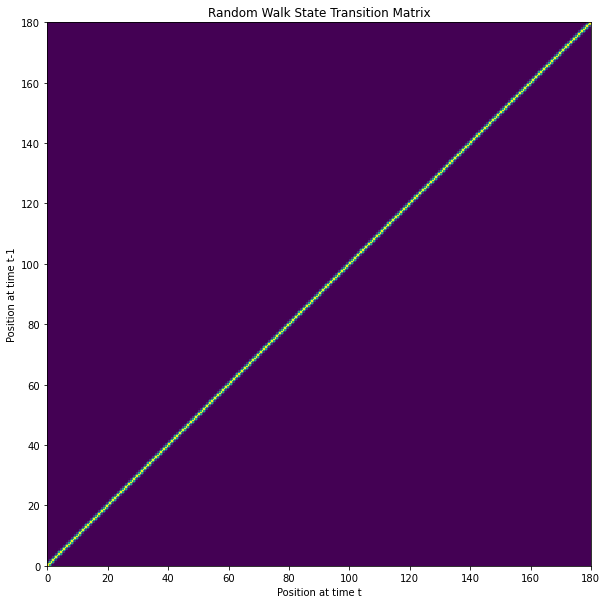

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

edge1, edge2 = np.meshgrid(decoder.environment.place_bin_edges_, decoder.environment.place_bin_edges_)
ax.pcolormesh(edge1, edge2, decoder.state_transition_.T, vmin=0.0, vmax=np.percentile(decoder.state_transition_, 99.9))
ax.set_title("Random Walk State Transition Matrix")
ax.set_ylabel("Position at time t-1")
ax.set_xlabel("Position at time t")
ax.axis("square")

In [17]:
time_ind = slice(0, 50000)

results = decoder.predict(spikes[time_ind], time=time[time_ind])
results

<xarray.Dataset>
Dimensions:            (time: 50000, position: 342)
Coordinates:
  * time               (time) float64 0.0 0.001 0.002 0.003 ... 50.0 50.0 50.0
  * position           (position) float64 0.2632 0.7895 1.316 ... 179.2 179.7
Data variables:
    likelihood         (time, position) float64 0.9975 0.9976 ... 0.9951 0.9946
    causal_posterior   (time, position) float64 0.002925 0.002925 ... 3.271e-50
    acausal_posterior  (time, position) float64 0.06012 0.08011 ... 3.271e-50
Attributes:
    data_log_likelihood:  -918.8115693106297

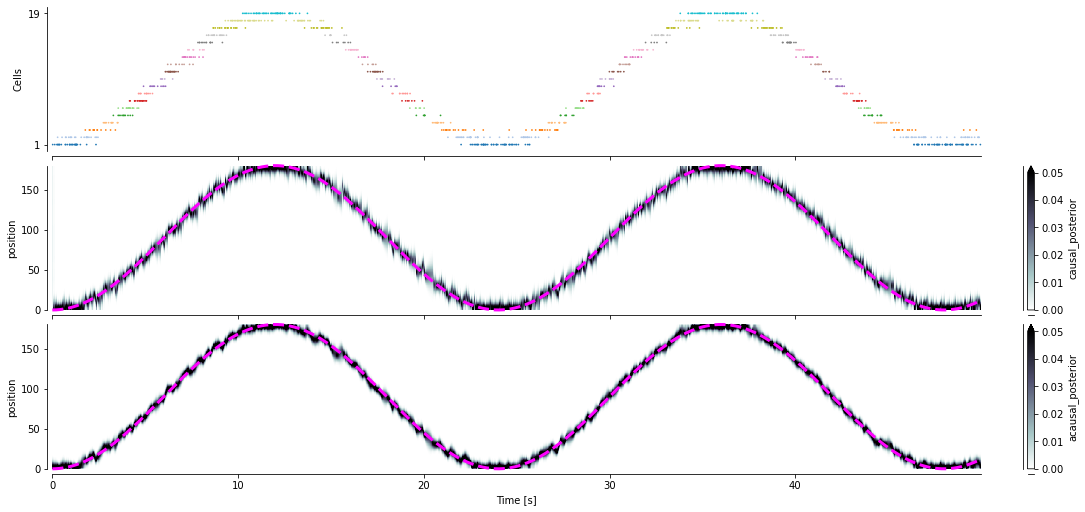

In [18]:
fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15, 7))

spike_ind, neuron_ind = np.nonzero(spikes[time_ind])
c = [cmap.colors[ind] for ind in neuron_ind]
axes[0].scatter(time[spike_ind], neuron_ind + 1, c=c, s=0.5, clip_on=False)
axes[0].set_yticks((1, spikes.shape[1]))
axes[0].set_ylabel('Cells')

results.causal_posterior.plot(x="time", y="position", ax=axes[1], cmap="bone_r", vmin=0.0, vmax=0.05, clip_on=False)
axes[1].plot(time[time_ind], position[time_ind], color="magenta", linestyle="--", linewidth=3, clip_on=False)
axes[1].set_xlabel("")
results.acausal_posterior.plot(x="time", y="position", ax=axes[2], cmap="bone_r", vmin=0.0, vmax=0.05, clip_on=False)
axes[2].plot(time[time_ind], position[time_ind], color="magenta", linestyle="--", linewidth=3, clip_on=False)
axes[2].set_xlabel('Time [s]')
sns.despine(offset=5)

In [21]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform, Identity


movement_var = estimate_movement_var(position, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [[RandomWalk(movement_var=movement_var * 120),  Uniform(), Identity()],
                                [Uniform(),                                   Uniform(), Uniform()],
                                [RandomWalk(movement_var=movement_var * 120), Uniform(), Identity()],
                               ]

classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    spike_model_penalty=0.5,
)
classifier.fit(position, spikes)

SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='', movement_var=33.31009971953083, movement_mean=0.0, use_diffusion=True),
                                                     Uniform(environment_name='', environment2_name=None),
                                                     Identity(environment_name='')],
                                                    [Uniform(environment_name='', environment2_name=None),
                                                     Uniform(environment_name='', environment2_name=None),
                                                     Uniform(e...
                       environments=(Environment(environment_name='', place_bin_size=0.5268625668325884, track_graph=None, edge_order=None, edge_spacing=None, is_track_interior=None, position_range=None, infer_track_interior=True),),
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
            

In [22]:
from replay_trajectory_classification.misc import TRANSITION_TO_CATEGORY, STATE_COLORS

def plot_classification(replay_time, test_spikes, results):
    fig, axes = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=True, sharex=True)
    spike_time_ind, neuron_ind = np.nonzero(test_spikes)
    axes[0].scatter(replay_time[spike_time_ind], neuron_ind, color='black', zorder=1,
                    marker='|', s=80, linewidth=3)
    axes[0].set_yticks((0, test_spikes.shape[1]))
    axes[0].set_ylabel('Neuron Index')
    replay_probability = results.acausal_posterior.sum('position')
    for state, prob in replay_probability.groupby('state'):
        axes[1].plot(prob.time, prob.values, linewidth=4, label=state, color=STATE_COLORS[state])
    axes[1].set_ylabel('Probability')
    axes[1].set_yticks([0, 1])
    axes[1].set_ylim((-0.01, 1.05))
    axes[1].legend(bbox_to_anchor=(1.15, 0.95), loc='upper right', fancybox=False, shadow=False,
                   ncol=1, frameon=False)
    
    results.acausal_posterior.sum('state').plot(
        x='time', y='position', robust=True, vmin=0.0, ax=axes[2])
    axes[2].set_ylabel('Position [cm]')
    plt.xlim((replay_time.min(), replay_time.max()))
    axes[-1].set_xlabel('Time [ms]')
    sns.despine()

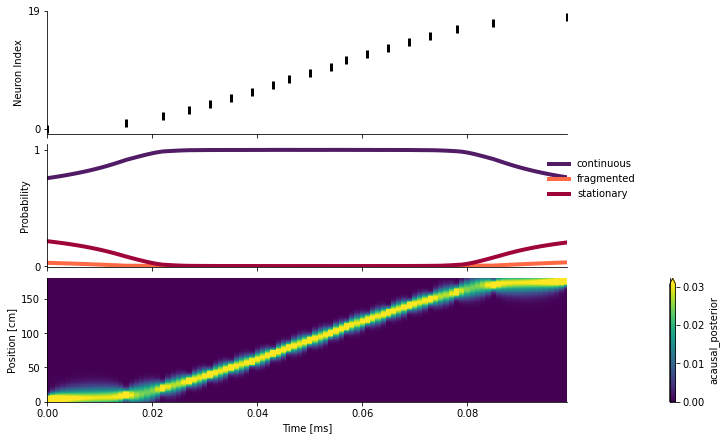

In [23]:
from replay_trajectory_classification.sorted_spikes_simulation import make_continuous_replay

replay_time, test_spikes = make_continuous_replay()
state_names = ['continuous', 'fragmented', 'stationary']
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)